# Instructions

*Text Adventure Games* are games in which the player interacts with a rich world only through text. Text adventure games predate computers with graphics. However, in many ways they are more complex than conventional video games because they can involve complicated interactions (e.g., "build a rope bridge") that require a fair amount of imagination. Indeed, text adventure games are used as [research testbeds](https://arxiv.org/abs/1909.05398) for natural language processing agents.

The canonical text adventure game is [Zork](https://en.wikipedia.org/wiki/Zork), in which the player discover an abandoned underworld realm full of treasure. You can find online playable versions.

A text game is made up of individual locations--also called "rooms", though they need not be indoor enclosed spaces as the term might imply. The agent can move between rooms and interact with objects by typing in short commands like "move north" and "take lamp".

In this assignment, we will use a special package that implements text worlds for testing agents: [TextWorld-Express](https://github.com/cognitiveailab/TextWorldExpress). Textworld-Express simplifies text worlds in a few ways: it uses a reduced set of text commands, and rooms laid out in a grid.
TextWorld-Express also implements a few different game objectives, such as cooking, and searching for coins.
TextWorld-Express generates world configurations, so we will need to implement algorithms that are able to complete different game objectives in different world configurations.

In this assignment, our agents will play two different games:
- Coin Game: a  game in which the agent must search for and pick up a single coin.
- Map Reader: a game in which the agent must find a coin and return it to a box at the starting location.

We will be implementing three different agent algorithms: breadth-first search (BFS), depth-first search (DFS), and A*.

You are only allowed to use a restricted set of libraries for this assignment. All packages that come with the default Python installation are permitted, as well as textworld-express, graphviz, and pydot, which are loaded as part of this notebook.

**Notes:**
- If you break execution of a cell running the game engine, you may put TextWorld-Express in an un-recoverable state. If this happens, you will need to reset your kernel/runtime.
- In the Map Reader game, you must use a single search loop (you cannot run a search to the coin and then a separate search to the box). You cannot write specialized code for handling the Map Reader game. You cannot memorize the path to the coin and then reverse it.
- In the Map Reader game, you cannot use the map information (it isn't really helpful anyway).
- You cannot filter any actions. We've already filtered out the actions that we don't want your agent to have to consider. For example, the "take map" action is never helpful, but you must explore it. Your implementations should quickly realize that that action creates a state self-loop and disregard it as part of the basic BFS, DFS, and A* search algorithms.
- Do not change the data within the global variables containing environment data that are loaded from file.

# Install

Install the TextWorld-Express engine, and graphviz and pydot for visualization.

In [3]:
%pip install textworld-express
%pip install graphviz
%pip install pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.4 MB/s eta 0:00:00


# Imports

In [4]:
from textworld_express import TextWorldExpressEnv
import graphviz
import pydot
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
from collections import namedtuple
import re
import os
import copy
import json
import math
import random
import networkx as nx
from itertools import combinations
from collections import deque
import heapq

**NOTE:** You should not modify the below cell in any way whatsoever. You do not need to run this cell for the assignment. It is solely for the autograder. Modifying this cell in any way will impact your score for the assignment.

In [5]:
from utils import SEED, ENV, GAME_TYPE, GAME_PARAMS
from utils import GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES

# Load a Game

Set the random seed for repeatablity

In [6]:
SEED = 3

Initialize the game environment. `ENV` is a global that encapulates the environment.

In [7]:
ENV = TextWorldExpressEnv(envStepLimit=100)

Set the game generator to generate a particular game (coin game or map reader)

In [8]:
GAME_TYPE = "coin"
GAME_PARAMS = "numLocations=5,includeDoors=1,numDistractorItems=0"
ENV.load(gameName=GAME_TYPE, gameParams=GAME_PARAMS)

# TextWorld API Primer

This section gives the basics of the TextWorld API.

**Reset the game engine.** `ENV.reset()` provides an observation, the text of the current local world, and a data structure called `infos`, which contains a variety of additional information about the current local world.

In [9]:
obs, infos = ENV.reset(seed=SEED, gameFold="train", generateGoldPath=True)
print(obs)
print(infos)

You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. 
To the South you see a closed sliding patio door. To the West you see a closed frosted-glass door. 
{'observation': 'You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dis

**Valid actions.** The actions that an agent can perform are part of the `infos` dictionary.

In [10]:
infos['validActions']

['look around',
 'close door to west',
 'move west',
 'open door to south',
 'open door to west',
 'inventory',
 'move south',
 'close door to south']

**Execute an action.** Actions are executed using `ENV.step()`, which returns the new observation for the agent's new state, a reward value, a boolean indicating if the agent has reached the end of the game, and the `infos` for the current state. Here is the code to choose a random valid action and execute it.

In [11]:
# Pick a random action
random_action = random.choice(infos['validActions'])
print("action:", random_action)
# Execute the action
obs, reward, done, infos = ENV.step(random_action)
print(obs)
print("reward:", reward)
print("done?", done)
print("infos:", infos)

action: move south
You can't move there, the door is closed. 
reward: 0.0
done? False
infos: {'observation': "You can't move there, the door is closed. ", 'look': 'You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. \nTo the South you see a closed sliding patio door. To the West you see a closed frosted-glass door. ', 'inventory': 'Inventory (maximum capacity is 2 items): \n  Your inventory is currently empty.\n', 'validActions': ['close door to west', 'move west', 'open door to south', 'inventory', 'close door to south', 'move south', 'open door to west', 

The environment knows the "gold path", which is the solution sequent of actions. This in not guaranteed to be optimal. *You are prohibited from calling this function as part of your code solutions to the homework problems.*

In [12]:
ENV.getGoldActionSequence()

['look around',
 'open door to south',
 'open door to west',
 'move west',
 'move east',
 'move south',
 'open door to east',
 'move east',
 'take coin']

# Load Data for Assignments

For this assignment, we provide data for several combinations of game type, seed, and game parameters. You can use this data to test your agent. It includes several ways of achieving full-observability in an otherwise partially observable environment. Each unique combination of game type, seed, and game parameters is stored in a file with filename `gametype+parameters+seed.json`. For example: "mapreader+numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0+seed=3.json".

A function to read in a file that describes the environment for a game type, set of parametes, and a seed. This function assumes that an appropriately named file is available in the filesystem.

In [13]:
def read_environment_file(game_type, game_params, seed):
  # Open file
  with open(game_type + '+' + game_params + '+seed=' + str(seed) + '.json', 'r') as f:
    # Read file
    data = json.load(f)
    # Grab each part of the json file and make sure it is formatted properly
    graph = [tuple(x) for x in data['graph']]
    world_state_hash = data['world states']
    world_map = [tuple(x) for x in data['world map']]
    world_observation_hash = data['world state observations']
    world_map_observations = data['world map observations']
    coordinates = data['coordinates']
    return graph, world_state_hash, world_observation_hash, world_map, world_map_observations, coordinates

Download and extract a bunch of files describing different environments.

**Note:** You may run into issues with this cell, specifically running the `wget` command. If this is the case, try uncommenting the code block directly below it which uses a `cURL` command to load the data.

If neither of these options work for you to load the data, you can manually navigate to the Dropbox links, download the files to your current working directory, and run the `tar` command only.

In [14]:
if not os.path.isfile('coin.tar.gz'):
  !wget -O coin.tar.gz 'https://www.dropbox.com/scl/fi/h3lxykcawrwjbs4fn46if/coin.tar.gz?rlkey=xofjqe78btipho9szyvqmp9xp&dl=0'
  !tar -xzvf coin.tar.gz
if not os.path.isfile('mapreader.tar.gz'):
  !wget -O mapreader.tar.gz 'https://www.dropbox.com/scl/fi/kxvyxhr5g901ln7yd12u3/mapreader.tar.gz?rlkey=x65hlidwifegd8mslp7cfvb4e&dl=0'
  !tar -xzvf mapreader.tar.gz

# NOTE: UNCOMMENT THE BELOW BLOCK IF RUNNING THE WGET COMMANDS FAIL
# if not os.path.isfile('coin.tar.gz'):
#   !curl -L -o coin.tar.gz 'https://www.dropbox.com/scl/fi/h3lxykcawrwjbs4fn46if/coin.tar.gz?rlkey=xofjqe78btipho9szyvqmp9xp&dl=0'
#   !tar -xzvf coin.tar.gz
# if not os.path.isfile('mapreader.tar.gz'):
#   !curl -L -o mapreader.tar.gz 'https://www.dropbox.com/scl/fi/kxvyxhr5g901ln7yd12u3/mapreader.tar.gz?rlkey=x65hlidwifegd8mslp7cfvb4e&dl=0'
#   !tar -xzvf mapreader.tar.gz

--2024-09-23 20:25:14--  https://www.dropbox.com/scl/fi/h3lxykcawrwjbs4fn46if/coin.tar.gz?rlkey=xofjqe78btipho9szyvqmp9xp&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9c0163900b2bd6ae9563958264.dl.dropboxusercontent.com/cd/0/inline/CbLBlBOJ_hL_rrBGzTcO3UegS6Ev8DcZznXWIjrcxaCjjU-pqdd_sZcs6GEyhh9D8CyQ484FI82G0m8mfvu8PcmRtwksFEBm6zkBiMak8YdYWynNcR7mNyGgVQL6gCs1M_EE8sPJLxCak-H_Zv7JZQ3Z/file# [following]
--2024-09-23 20:25:15--  https://uc9c0163900b2bd6ae9563958264.dl.dropboxusercontent.com/cd/0/inline/CbLBlBOJ_hL_rrBGzTcO3UegS6Ev8DcZznXWIjrcxaCjjU-pqdd_sZcs6GEyhh9D8CyQ484FI82G0m8mfvu8PcmRtwksFEBm6zkBiMak8YdYWynNcR7mNyGgVQL6gCs1M_EE8sPJLxCak-H_Zv7JZQ3Z/file
Resolving uc9c0163900b2bd6ae9563958264.dl.dropboxusercontent.com (uc9c0163900b2bd6ae9563958264.dl.dropboxusercontent.com)... 162.125.5.15, 26

Set the game type and game parameters.

In [15]:
# NOTE: THIS CODE IS USED TO SET UP A COIN ENVIRONMENT FOR TESTING.
GAME_TYPE = "coin"
GAME_PARAMS = "numLocations=5,includeDoors=1,numDistractorItems=0"

# NOTE: UNCOMMENT THIS CODE TO USE THE MAPREADER ENVIRONMENT FOR TESTING.
#GAME_TYPE="mapreader"
#GAME_PARAMS="numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0"

SEED = 3

Load all the environment information into global variables (global variables described below).

In [16]:
GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES =  read_environment_file(GAME_TYPE, GAME_PARAMS, SEED)
ENV.load(gameName=GAME_TYPE, gameParams=GAME_PARAMS)

## Data Structures Information

**Map Information:**

```WORLD_MAP``` is a list of transitions of the form ```(loc1, 'move x', loc2)```
For example
```
[('kitchen', 'move west', 'pantry'),
 ('pantry', 'move east', 'kitchen'),
 ('kitchen', 'move south', 'backyard'),
 ('backyard', 'move north', 'kitchen'),
 ('backyard', 'move east', 'corridor'),
 ('corridor', 'move west', 'backyard'),
 ('corridor', 'move north', 'bedroom'),
 ('bedroom', 'move south', 'corridor')]
 ```

```WORLD_MAP_OBSERVATIONS``` is a hash that maps location name to observation text. This is per location and the observation is the one that is seen the first time a location is encountered (it could be changed by the agent).

For example:
```
 {'kitchen': 'You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. \nTo the South you see a closed sliding patio door. To the West you see a closed frosted-glass door. \nempty'}
 ```

 ```COORDINATES``` is a hash that maps location name to ```(x, y)``` coordinates.

 For example:
 ```
 {'kitchen': (0, 0),
 'pantry': (-1, 0),
 'backyard': (0, -1),
 'corridor': (1, -1),
 'bedroom': (1, 0)}
 ```

 **State Graph information:**

 Each state has a unique id string (e.g., `'8289070664768900319'`).

```GRAPH``` is a list of tuples in the form of ```(state_hash1, state_hash2, action)```. This gives all the possible state-to-state transitions.

For example:
```
[('3879096835221616523', '3879096835221616523', 'close door to west'),
 ('3879096835221616523', '3879096835221616523', 'move west'),
 ('3879096835221616523', '8289070664768900319', 'open door to south'),
 ('3879096835221616523', '5409443512146995218', 'open door to west'),
 ('3879096835221616523', '3879096835221616523', 'move south'),
 ('3879096835221616523, '3879096835221616523', 'close door to south')]
 ```

 ```WORLD_STATE_HASH``` maps a unique state id to a dictionary containing information about location, inventory, information about each room in the environment, and information about all the doors in the environment.

 Room information contains the objects in the room. If the object is a string (e.g., `'a box'`). If the object has an attribute, then the object is given as a tuple with the first element being the name of the object and the second element being the attribute (e.g., `('a box', 'contains a coin')`).

 Doors can be `'open'` or `'closed'`.

 For example:
 ```
 {'3879096835221616523':
   {'location': 'kitchen',
    'inventory': 'empty',
    'rooms': {'backyard': {'things': [('a garden', 'has nothing on it'),
                                      'barbeque',
                                      ('patio table', 'has nothing on it')]},
              'bedroom': {'things': [('a desk chair', 'has nothing on it'),
                                     ('wardrobe', 'is closed')]},
              'corridor': {'things': ['a coin',
                                      ('umbrella stand', 'has nothing on it')]}},
    'doors': {'frosted-glass door': 'closed',
              'screen door': 'closed',
              'sliding patio door': 'closed',
              'wood door': 'closed'}}}
```

You can get the number of unique states in the environment with `len(WORLD_STATE_HASH)`.

```WORLD_OBSERVATION_HASH``` maps unique state ids to observations.

For example:
```
{'3879096835221616523': 'You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. \nTo the South you see a closed sliding patio door. To the West you see a closed frosted-glass door. \nInventory (maximum capacity is 2 items): \n  Your inventory is currently empty.\n'}
```

# Helper Functions

In [17]:
### Add the inventory to the world observation text.
### This gives a more complete text observation.
# def obs_with_inventory(obs, env):
#   return obs + '\n' + look_at_inventory(env)
def obs_with_inventory(obs, inv):
  return obs + '\n' + inv

### Pull the inventory items out of the observation text that includes
### the inventory (from obs_with_inventory())
def parse_inventory(obs):
  # Search for the inventory in the observation
  m = re.search(r'Inventory[a-zA-Z0-9 \(\)]*:\s*([a-zA-Z0-9 \.\n]+)', obs)
  if m is not None:
    # See if there is something there other than "empty"
    if 'empty' not in m.group(1):
      return m.group(1).replace('\n', '')
  return 'empty'

### Pull the location out of the observation text.
def obs_location(obs):
  first_sentence = obs.split('.')[0].split(' ')
  start = first_sentence.index('the') + 1
  return ' '.join(first_sentence[start:])

### Produces an identifier for a state dictionary.
### (Not guaranteed to be unique because of the abs, but shouldn't be a problem)
def hash_state(state):
  return str(abs(hash(json.dumps(state))))

### Parse the objects out of an observation
def parse_things(obs):
  things1 = re.findall(r'[yY]ou \w*\s*see [aA]? ([a-zA-Z0-9\- ]+)\,? that ([a-zA-Z0-9\-, ]+).', obs)
  things2 = re.findall(r'[tT]here is \w*\s*([a-zA-Z0-9\- ]+)\,? that ([a-zA-Z0-9\-, ]+).', obs)
  things3 = re.findall(r'[tT]here is \w*\s*([a-zA-Z0-9\- ]+)\.', obs)
  things3 = list(filter(lambda s:'that' not in s, things3))
  things4 = re.findall(r'[yY]ou \w*\s*see a ([a-zA-Z0-9\- ]+)\.', obs)
  things4 = list(filter(lambda s:'door' not in s and 'that' not in s, things4))
  return list(map(lambda x: list(x) if type(x) is tuple else x,
                  things1 + things2 + things3 + things4))

### Parse doors out of an observation
def parse_doors(obs, location):
  # Split the sentences in the observation
  sentences = obs.split('.')
  doors = [] # Collect the doors here
  # The directions one can move on a grid
  dirs = re.compile('west|east|south|north')
  # Look at each sentence for reference to an open door or a closed door
  for sentence in sentences:
    # Regular expression to find open and closed doors
    m_open = re.search(r'open ([a-z\- ]*door)', sentence)
    m_closed = re.search(r'closed ([a-z\- ]*door)', sentence)
    # The sentence also needs to reference a direction
    dir = dirs.search(sentence.lower())
    # Do we find a sentence that meets the criteria? If so, we have a door
    if dir is not None:
      if m_open is not None:
        doors.append((m_open[1] + ' (' + location + ') ' + dir[0], 'open'))
      elif m_closed is not None:
        doors.append((m_closed[1] + ' (' + location + ') ' + dir[0], 'closed'))
  return doors

### Parse room information
def parse_room(obs):
  things = sorted(parse_things(obs), key=lambda x: x[0] if type(x) is list else x)
  return {'things': things}

### Make a world state dictionary from an observation and inventory and world map hash.
### To do this, we need to go through all the states because we need to know
### all the rooms and doors that exist, and we will assume nothing changes with
### respect to any rooms that we are not currently observing.
def make_world_state(observation, inventory, world_map_hash_table):
  # Get all the rooms
  rooms = list(world_map_hash_table.keys())
  # Build an empty state dictionary
  world_state = {'location': obs_location(observation),
                 'inventory': inventory,
                 'rooms': {},
                 'doors': {}}
  all_doors = [] # Store all doors
  rooms_hash = {} # A dictionary holding information about each room
  # Iterate through all rooms, sorted so they are always in the same order
  for room in sorted(rooms):
    # Get the room observation
    room_obs = world_map_hash_table[room]
    # Parse out all the objects in the room
    rooms_hash[room] = parse_room(room_obs)
    # Get all the doors in the room, avoid duplicates
    all_doors = list(set(all_doors + parse_doors(room_obs, room)))
  # Add the rooms to the state dictionary
  world_state['rooms'] = rooms_hash
  # Add all the doors and their statuses to the state dictionary
  for door, status in sorted(all_doors, key=lambda x:x[0]):
    world_state['doors'][door] = status
  # Return the state dictionary
  return world_state

Functions for parsing world state observations.

`world_state_to_string()` is a function for printing a world state dictionary in a reader-friendly (pretty) fashion. It takes a world state dictionary object (described below). There is an optional input, `ignore_keys` to tell the function to not print certain keys in any part of the world state dictionary.

In [18]:
### Turn a list into a nice looking string
def list_to_pretty_string(lst, indent=0):
  out = ''
  indent_str = ' '*indent
  for item in lst:
    out = out + indent_str + '- ' + str(item) + '\n'
  return out

### Turn a dictionary into a nice looking string
### ignore_keys is a list of keys to bypass so they are not printed out.
def dict_to_pretty_string(d, indent = 0, ignore_keys = []):
  out = '' # The output
  # Append whitespace to front of string based on how many recursive levels deep
  indent_str = ' '*indent
  # Iterate through dictionary keys
  for n, key in enumerate(d):
    # Check for keys to ignore
    if key not in ignore_keys:
      # Get the value for the key
      value = d[key]
      # Produce output string information starting with the key
      out = out + indent_str + key + ': '
      if type(value) is dict:
        # If the value is a dictionary, recurse
        out = out + '\n' + dict_to_pretty_string(value, indent = indent+1, ignore_keys = ignore_keys)
      elif type(value) is list:
        # If the value is a list, convert list to string
        out = out + '\n' + list_to_pretty_string(value, indent = indent+1)
      else:
        # Just print the value as a string and put a newline
        end = '\n' if n < len(d)-1 else ''
        out = out + str(value) + end
  return out

### Take a world state dictionary and make it a nice-looking string
### ignore_keys is a list of keys to bypass so they are not printed out.
def world_state_to_string(world_state, ignore_keys = []):
  out = dict_to_pretty_string(world_state, ignore_keys = ignore_keys)
  return out

Code for rendering a map of the environment.

In [19]:
def render_map(world_map, world_map_observations, coordinates, filename = 'map'):
  # Create graphviz root container
  dot = graphviz.Digraph()
  names = [] # These are the locations we have added to the graph
  # Iterate through all the arcs in the world map
  for arc in world_map:
    # Make a node for the source of the arc
    if arc[0] not in names:
      dot.node(name=str(arc[0]), label=obs_location(world_map_observations[arc[0]]) + ' ' + str(coordinates[arc[0]]))
      names.append(arc[0])
    # Make a node for the target of the arc
    if arc[2] not in names:
      dot.node(name=str(arc[2]), label=obs_location(world_map_observations[arc[2]]) + ' ' + str(coordinates[arc[2]]))
      names.append(arc[2])
    # Make an edge
    dot.edge(str(arc[0]), str(arc[2]), label=arc[1].split(' ')[1])
  # Render to file
  dot.render(filename + '.gv', view=False)
  (graph,) = pydot.graph_from_dot_file(filename + '.gv')
  graph.write_png(filename + '.png')
  return Image(filename + '.png')

Code to render the state space.

In [20]:
def render_state_space(graph, world_state_hash, ignore_keys = [], filename = 'space'):
  # Create graphviz root container
  dot = graphviz.Digraph()
  nodes = []
  edges = []
  for arc in graph:
    parent, child, act = arc
    parent_name = parent
    child_name = child
    if child not in nodes:
      dot.node(name=child_name, label=world_state_to_string(world_state_hash[child], ignore_keys = ignore_keys))
      nodes.append(child)
    if parent not in nodes:
      dot.node(name=parent_name, label=world_state_to_string(world_state_hash[parent], ignore_keys = ignore_keys))
      nodes.append(parent)
    if (parent, child, act) not in edges:
      dot.edge(parent_name, child_name, label=act)
      edges.append((parent, child, act))
  # Render to file
  dot.render(filename + '.gv', view=False)
  (graph,) = pydot.graph_from_dot_file(filename + '.gv')
  graph.write_png(filename + '.png')
  return Image(filename + '.png')

## Render the map

This map is rendered to file (by default "map.png" and "map.gv.pdf") and also displayed in the cell below.

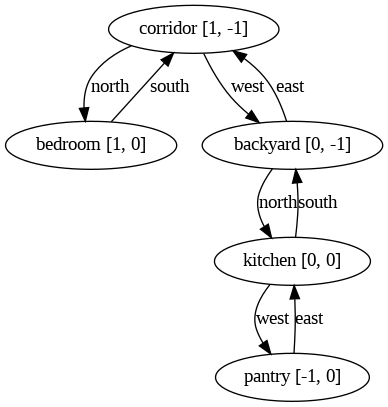

In [21]:
render_map(WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES)

## Render the State Space

This graph is rendered to file (by default "space.png" and "space.gv.pdf") and also displayed in the cell below.

Set `render=True` to render the state space graph

**This method takes a while to run**

In [22]:
render = False
if render:
    render_state_space(GRAPH, WORLD_STATE_HASH)

# State Space Search Helper Functions

These functions are useful for BFS, DFS, and A*.

In particular, `make_world_state()` takes a text observation and inventory information and constructs a state dictionary. `update_world_state()` takes a state dictionary and new observation text and new inventory text and returns an updated state dictionary.

In [23]:
### Take an existing state dictionary and update it with new observation and
### inventory data. Assume nothing changes other than with the new observation
### and inventory.
def update_world_state(old_world_state, new_observation, new_inventory):
  # Get the new location
  new_location = obs_location(new_observation)
  # Make a deep copy of the old state dictionary
  new_world_state = copy.deepcopy(old_world_state)
  # Set the new location
  new_world_state['location'] = new_location
  # Set the new inventory
  new_world_state['inventory'] = new_inventory
  # Parse the current room and swap it into the state dictionary
  new_world_state['rooms'][new_location] = parse_room(new_observation)
  # Get the doors in this location and their statuses
  doors = parse_doors(new_observation, new_location)
  # Add new door information to the state dictionary
  for door, status in doors:
    new_world_state['doors'][door] = status
  # Return the state dictionary
  return new_world_state

The following are custom functions for resetting the environment and executing actions during state space search. Use these instead of `ENV.step()` and `ENV.reset()`.

`do_action_state_search()` is a wrapper for `ENV.step()` that processes the output into a state dictionary. Pass in the string indicating the action (e.g., `'move north'`), and a reference to the environment object. This function returns a dictionary containing: state id, state observation, agent inventory, and list of valid actions.

`reset_state_search()` is a wrapper for `ENV.reset()` that processes the output into a state dictionary. Pass in the environment object. This function returns
a dictionary containing: state id, state observation, inventory, list of valid actions, and a state dictionary.

In [24]:
### Do the action for state space search.
### This function returns the id of the new state, an observation, inventory,
### and list of valid actions.
def do_action_state_search(action, env):
  # Execute the action
  obs, reward, done, infos = env.step(action)
  # Execute the look action to get observation text
  # Make the modified observation with inventory added
  inv = infos['inventory']
  modified_obs = obs_with_inventory(infos['look'], inv)
  # Get the valid actions, except for 'inventory' and 'look'
  valid_actions = infos['validActions']
  valid_actions.remove('inventory')
  valid_actions.remove('look around')
  return {'id': hash_state(modified_obs),
          'observation': modified_obs,
          'inventory': parse_inventory(inv),
          'valid actions': valid_actions}

### Helper function to convert a state dictionary to an id
def state_dict_to_id(state):
  return list(WORLD_STATE_HASH.keys())[list(WORLD_STATE_HASH.values()).index(state)]

### Reset environment for state space. This function returns initial state
### information as a dictionary containing, state id, observation, inventory,
### valid actions, and state dictionary.
def reset_state_search(env, world_map_observations):
  # Reset environment
  obs, infos = env.reset(seed=SEED, gameFold="train", generateGoldPath=True)
  # Get modified observation text with inventory included
  inv = infos['inventory']
  modified_obs = obs_with_inventory(infos['look'], inv)
  # Get the valid actions, except for 'inventory' and 'look'
  valid_actions = infos['validActions']
  valid_actions.remove('inventory')
  valid_actions.remove('look around')
  # Create the world state dictionary
  init_world_state = make_world_state(modified_obs,
                                      parse_inventory(inv),
                                      world_map_observations)
  # Figure out the id of this state dictionary
  id = state_dict_to_id(init_world_state)
  return {'id': id,
          'observation': modified_obs,
          'inventory': parse_inventory(inv),
          'valid actions': valid_actions,
          'state': init_world_state}

# Implement Goal State Function

**Step 1:** Implement the `is_goal()` function for the Coin Game and Map Reader games. The `is_goal()` functions take in a state. This can be whatever you want. These methods are only going to be used in your own solution code below, and we will not be checking this function for correctness
 (though if it is incorrect it will cause your solutions to fail!).  Possibilities include the hash ID of a state, or a state dictionary (see the description of `WORLD_STATE_HASH` above). You are allowed to access global variables.

In [25]:
def is_goal_coin(state):
  is_goal = False
  ### YOUR CODE BELOW HERE ###
  #state is a key to the dictionary
  new_state = WORLD_STATE_HASH[state]
  if 'coin' in new_state['inventory']:
    is_goal = True
  ### YOUR CODE ABOVE HERE ###
  return is_goal

In [26]:
def is_goal_mapreader(state):
  is_goal = False
  ### YOUR CODE BELOW HERE ###
  items = WORLD_STATE_HASH[state]
  for room in items['rooms']:
    if 'box' in str(items['rooms'][room]['things']) and 'coin' in str(items['rooms'][room]['things']):
      is_goal = True



  ### YOUR CODE ABOVE HERE ###
  return is_goal

# Implement Successor Function

**Step 2.** Implement `get_successors()`. The function takes a state, however you wish to represent it. You should look up the state in `GRAPH`. You are allowed to access global variables.

In [28]:
def get_successors(state):
  successors = []
  ### YOUR CODE BELOW HERE ###
  for current_state, next_state, action in GRAPH:
    if current_state == state:
      successors.append((next_state, action))

  ### YOUR CODE ABOVE HERE ###
  return successors

# Breadth-First Search (BFS)

**Step 3.** Implement BFS. The function takes the following parameters:

- init_state_info: the structure given by `reset_state_search()` containing state id, state dictionary, initial observation, initial inventory, and valid actions. This is provided by `reset_state_search()`, for example:
```
{'id': '8289070664768900319',
 'observation': 'You are in...',
 'inventory': 'a coin',
 'valid actions': ['move north', 'move south', ...],
 'state': {'location': 'kitchen',
           'inventory': 'a coin',
           'rooms': {'living room': {'things': ['a box']},
                     'kitchen': {'things': []}}
          }
}
```
- graph: a list of state transitions (i.e., `GRAPH`)
- world_state_hash: a dictionary that maps world state ids to state dictionaries (i.e., `WORLD_STATE_HASH`)
- is_goal: a function that takes a state and returns True or False whether that state is a goal state (i.e., `is_goal_coin_game` or `is_goal_map_reader`).
- extras: not used

The function should return two values:
- The plan: a list of actions, e.g. `[action_string_1, action_string_2, ..., action_string_n]`
- A list of all states visited during the search, e.g., `[state_1, state_2, ..., state_n]`. The states should be represented as state ids.

In [29]:
def bfs(init_state_info, graph, world_state_hash, is_goal = lambda s: True, **extras):
  the_plan = []
  visited_states = []
  ### YOUR CODE BELOW HERE ###
  visited_states = set()
  queue = deque([(init_state_info['id'], [], init_state_info)])

  visited_states.add(init_state_info['id'])

  while queue:
    #if this one is in visited, then dont do anything, otherwise add it to isited
    current_state_id, path_to_current, current_state_info = queue.popleft()

    if current_state_id not in visited_states:
      visited_states.add(current_state_id)

    if is_goal(current_state_id):
      the_plan = path_to_current
      return the_plan, list(visited_states)





    for next_state, action in get_successors(current_state_id):
      if next_state not in visited_states:
        #visited_states.add(next_state)
        new_path = path_to_current + [action]
        next_state_info = world_state_hash[next_state]
        queue.append((next_state, new_path, next_state_info))

  visited_states = list(visited_states)
  ### YOUR CODE ABOVE HERE ###
  return the_plan, visited_states

Initialize the environment.

In [30]:
init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
print(world_state_to_string(init_state_info['state']))

location: kitchen
inventory: empty
rooms: 
 backyard: 
  things: 
   - ['a garden', 'has nothing on it']
   - ['a workbench', 'has nothing on it']
   - barbeque
   - ['clothes line', 'has nothing on it']
   - ['patio chair', 'has nothing on it']
   - ['patio table', 'has nothing on it']
 bedroom: 
  things: 
   - ['a desk chair', 'has nothing on it']
   - ['a night stand', 'has nothing on it']
   - ['bed', 'has nothing on it']
   - ['chest of drawers', 'is closed']
   - ['desk', 'has nothing on it']
   - ['dressing table', 'has nothing on it']
   - ['wardrobe', 'is closed']
 corridor: 
  things: 
   - a coin
   - ['a shoe cabinet', 'is closed']
   - ['coat hanger', 'has nothing on it']
   - ['hat rack', 'has nothing on it']
   - ['key holder', 'has nothing on it']
   - ['umbrella stand', 'has nothing on it']
 kitchen: 
  things: 
   - ['a cutlery drawer', 'is closed']
   - an oven
   - ['counter', 'has nothing on it']
   - ['dining chair', 'has nothing on it']
   - ['dishwasher', 'is c

Test BFS using the game environment loaded in earlier in the notebook

In [31]:
plan, visited = bfs(init_state_info, GRAPH, WORLD_STATE_HASH, is_goal = is_goal_coin)
print('The plan:', plan)
print('Number of visited states:', len(visited))

The plan: ['open door to south', 'move south', 'open door to east', 'move east', 'take coin']
Number of visited states: 30


# Depth-First Search (DFS)

**Step 4.** Implement DFS. The function takes the following parameters:

- init_state_info: the structure given by `reset_state_search()` containing state id, state dictionary, initial observation, initial inventory, and valid actions.
- graph: a list of state transitions (i.e., `GRAPH`)
- world_state_hash: a dictionary that maps world state ids to state dictionaries (i.e., `WORLD_STATE_HASH`)
- is_goal: a function that takes a state and returns True or False whether that state is a goal state (i.e., `is_goal_coin` or `is_goal_mapreader`).
- extras: not used

The function should return two values:
- The plan: a list of actions, e.g. `[action_string_1, action_string_2, ..., action_string_n]`
- A list of all states visited during the search, e.g., `[state_1, state_2, ..., state_n]`. The states should be represented as state ids.

**Note:** When implementing DFS, please visit neighbors in the ***reverse*** order of the neighbors as they are presented in `GRAPH`. For example, if the neighbors of a vertex in `GRAPH` were `['A', 'B', 'C']`, please visit them as `C` -> `B` -> `A`. If you are using a ***stack***, adding the neighbors in the given order to the stack will naturally have you visit them in reverse order (_this is a good exercise to think about_).

In [32]:
def dfs(init_state_info, graph, world_state_hash,
        is_goal = lambda s: True, **extras):
  the_plan = []
  visited_states = []
  ### YOUR CODE BELOW HERE ###
  visited_states = set()
  queue = deque([(init_state_info['id'], [], init_state_info)])

  visited_states.add(init_state_info['id'])

  while queue:
    #if this one is in visited, then dont do anything, otherwise add it to isited
    current_state_id, path_to_current, current_state_info = queue.pop()

    if current_state_id not in visited_states:
      visited_states.add(current_state_id)

    if is_goal(current_state_id):
      the_plan = path_to_current
      return the_plan, list(visited_states)





    for next_state, action in get_successors(current_state_id):
      if next_state not in visited_states:
        #visited_states.add(next_state)
        new_path = path_to_current + [action]
        next_state_info = world_state_hash[next_state]
        queue.append((next_state, new_path, next_state_info))

  ### YOUR CODE ABOVE HERE ###
  return the_plan, visited_states

Initialize the environment

In [33]:
init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
print(world_state_to_string(init_state_info['state']))

location: kitchen
inventory: empty
rooms: 
 backyard: 
  things: 
   - ['a garden', 'has nothing on it']
   - ['a workbench', 'has nothing on it']
   - barbeque
   - ['clothes line', 'has nothing on it']
   - ['patio chair', 'has nothing on it']
   - ['patio table', 'has nothing on it']
 bedroom: 
  things: 
   - ['a desk chair', 'has nothing on it']
   - ['a night stand', 'has nothing on it']
   - ['bed', 'has nothing on it']
   - ['chest of drawers', 'is closed']
   - ['desk', 'has nothing on it']
   - ['dressing table', 'has nothing on it']
   - ['wardrobe', 'is closed']
 corridor: 
  things: 
   - a coin
   - ['a shoe cabinet', 'is closed']
   - ['coat hanger', 'has nothing on it']
   - ['hat rack', 'has nothing on it']
   - ['key holder', 'has nothing on it']
   - ['umbrella stand', 'has nothing on it']
 kitchen: 
  things: 
   - ['a cutlery drawer', 'is closed']
   - an oven
   - ['counter', 'has nothing on it']
   - ['dining chair', 'has nothing on it']
   - ['dishwasher', 'is c

Test dFS using the game environment loaded in earlier in the notebook

In [34]:
plan, visited = dfs(init_state_info, GRAPH, WORLD_STATE_HASH, is_goal = is_goal_coin)
print('The plan:', plan)
print('Number of visited states:', len(visited))

The plan: ['open door to west', 'open door to south', 'close door to west', 'move south', 'open door to east', 'move north', 'open door to west', 'move south', 'close door to north', 'move east', 'take coin']
Number of visited states: 12


# Heuristic Functions

**Step 5.** Implement heuristic functions for Coin Game and Map Reader.

Heuristic functions takes a state as input (represented as a state ID), and returns a floating point value, which is the estimated distance to the goal.

In [35]:
### SOLUTION
def h_coin(state):
  h_value = 0.0
  ### YOUR CODE BELOW HERE ###
  start_room = WORLD_STATE_HASH[state]["location"]
  if is_goal_coin(state):
    h_value = 0.0
  else:
    coin_r = None
    for room in WORLD_STATE_HASH[state]["rooms"]:
      for things in WORLD_STATE_HASH[state]["rooms"][room]["things"]:
        if 'coin' in things:
          coin_r = room
          break
    if coin_r is not None:
      h_value = abs(COORDINATES[start_room][0] - COORDINATES[coin_r][0]) + abs(COORDINATES[start_room][1] - COORDINATES[coin_r][1])
    else:
      h_value = 1

  ### YOUR CODE ABOVE HERE ###
  return h_value

In [49]:
def h_mapreader(state):
  h_value = 0.0
  ### YOUR CODE BELOW HERE ###

  if is_goal_mapreader(state):
    return 0
  info = WORLD_STATE_HASH[state]
  curr_coordinates = COORDINATES[info['location']]

  if 'coin' not in info['inventory']:
    coin_r = 0
    for room in info['rooms']:
      if 'coin' in str(info['rooms'][room]['things']):
        coin_r = room
        break

    box_room = 0
    for room in info['rooms']:
      if 'box' in str(info['rooms'][room]['things']):
        box_room = room
        break

    box_coords = COORDINATES[box_room]
    coin_coords = COORDINATES[coin_r]
    h_value = math.dist(curr_coordinates, coin_coords) + math.dist(coin_coords, box_coords)

    # if you have the coin, h value is coin to box
    #if you dont have the coin, you to coin > coin to box
  else:
    #coin_r = 0
    #for room in info['rooms']:
      #if 'coin' in str(info['rooms'][room]['things']):
        #coin_r = room
        #break

    box_room = 0
    for room in info['rooms']:
      if 'box' in str(info['rooms'][room]['things']):
        box_room = room
        break

    #coin_coords = COORDINATES[coin_r]
    box_coords = COORDINATES[box_room]
    h_value = math.dist(curr_coordinates, box_coords)

  ### YOUR CODE ABOVE HERE ###
  return h_value

# A*

**Step 6.** Implement A*. The function takes the following parameters:

- init_state_info: the structure given by `reset_state_search()` containing state id, state dictionary, initial observation, initial inventory, and valid actions.
- graph: a list of state transitions (i.e., `GRAPH`)
- world_state_hash: a dictionary that maps world state ids to state dictionaries (i.e., `WORLD_STATE_HASH`)
- is_goal: a function that takes a state and returns True or False whether that state is a goal state (i.e., `is_goal_coin` or `is_goal_mapreader`).
- h_func: the heuristic function, takes a state and returns the estimated distance to the goal state (i.e., `h_coin` or `h_mapreader`).

The function should return two values:
- The plan: a list of actions, e.g. `[action_string_1, action_string_2, ..., action_string_n]`
- A list of all states visited during the search, e.g., `[state_1, state_2, ..., state_n]`. The states should be represented as state ids.

**NOTE**: Please break ties in the priority queue by going with **lower** state IDs first. So if you have two state IDs `1`, `2` with the same cost, please choose `1` first since its state id is lower. Since these state IDs are strings, please compare them as strings, not as integers. ***Do not use any other method for breaking ties.***

In [37]:
def a_star(init_state_info, graph, world_state_hash,
           is_goal = lambda state: True,
           h_func = lambda state: 0.0):
  the_plan = []
  visited_states = []
  ### YOUR CODE BELOW HERE ###

  #add a state hash

  s_hash = init_state_info['id']

  listToAdd = []
  heapq.heappush(listToAdd, (0, s_hash, [], 0))


  visited_states = set()
  while listToAdd:
    f_val, s_hash, path, cost = heapq.heappop(listToAdd)

    #pop visited>>?
    #visited_states.add(state_hash)

    if is_goal(s_hash):
      the_plan = path
      return the_plan, list(visited_states)

    #if this one is in visited, then dont do anything, otherwise add it to isited
    if s_hash not in visited_states:
      visited_states.add(s_hash)

      for successor_hash, successor_action in get_successors(s_hash):

        nextPath = path + [successor_action]
        nextCost = cost + 1

        f_val = h_func(successor_hash) + nextCost

        heapq.heappush(listToAdd, (f_val, successor_hash, nextPath, nextCost))

  visited_states = list(visited_states)

  ### YOUR CODE ABOVE HERE ###
  return the_plan, visited_states

Initialize the environment

In [38]:
init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
print(world_state_to_string(init_state_info['state']))

location: kitchen
inventory: empty
rooms: 
 backyard: 
  things: 
   - ['a garden', 'has nothing on it']
   - ['a workbench', 'has nothing on it']
   - barbeque
   - ['clothes line', 'has nothing on it']
   - ['patio chair', 'has nothing on it']
   - ['patio table', 'has nothing on it']
 bedroom: 
  things: 
   - ['a desk chair', 'has nothing on it']
   - ['a night stand', 'has nothing on it']
   - ['bed', 'has nothing on it']
   - ['chest of drawers', 'is closed']
   - ['desk', 'has nothing on it']
   - ['dressing table', 'has nothing on it']
   - ['wardrobe', 'is closed']
 corridor: 
  things: 
   - a coin
   - ['a shoe cabinet', 'is closed']
   - ['coat hanger', 'has nothing on it']
   - ['hat rack', 'has nothing on it']
   - ['key holder', 'has nothing on it']
   - ['umbrella stand', 'has nothing on it']
 kitchen: 
  things: 
   - ['a cutlery drawer', 'is closed']
   - an oven
   - ['counter', 'has nothing on it']
   - ['dining chair', 'has nothing on it']
   - ['dishwasher', 'is c

Test A*

In [39]:
plan, visited = a_star(init_state_info, GRAPH, WORLD_STATE_HASH,
                       h_func = h_coin,
                       is_goal = is_goal_coin)
print('The plan:', plan)
print('Number of visited states:', len(visited))

The plan: ['open door to south', 'move south', 'open door to east', 'move east', 'take coin']
Number of visited states: 13


# Testing Suite

Run all the environments that are in files in the file system. This produces a dictionary that relates game configuration (game type, game parameters, seed) to a tuple containing the plan and the visited states.

In [40]:
def run_all(algorithm):
  global GAME_TYPE, GAME_PARAMS, SEED
  global GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES
  files = os.listdir('.')
  results = {}
  for file in files:
    m = re.search(r'([a-z]+)\+([a-zA-Z0-9,=]+)\+seed\=([0-9]+).json', file)
    if m is not None and m.lastindex >= 3:
      GAME_TYPE = m[1]
      GAME_PARAMS = m[2]
      SEED = int(m[3])
      print(m[1], m[2], m[3])
      print('============ type=', GAME_TYPE, 'params=', GAME_PARAMS, 'seed=', SEED, '============')
      GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES = read_environment_file(GAME_TYPE, GAME_PARAMS, SEED)
      print(SEED, GAME_TYPE, GAME_PARAMS)
      ENV.load(gameName=GAME_TYPE, gameParams=GAME_PARAMS)
      init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
      plan, visited = algorithm(init_state_info, GRAPH, WORLD_STATE_HASH,
                                is_goal = eval('is_goal_' + GAME_TYPE),
                                h_func = eval('h_' + GAME_TYPE))
      results[(GAME_TYPE, GAME_PARAMS, SEED)] = (plan, visited)
  for setting in results.keys():
    plan, visited = results[setting]
    if plan is None or visited is None or len(plan) == 0 or len(visited) == 0:
      print("FAIL", setting)
  return results

## BFS Testing

Run BFS on all environments

In [41]:
results = run_all(bfs)
print(results)

mapreader numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0 2
============ type= mapreader params= numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0 seed= 2 ============
2 mapreader numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0
mapreader numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0 4
============ type= mapreader params= numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0 seed= 4 ============
4 mapreader numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0
coin numLocations=7,includeDoors=1,numDistractorItems=0 0
============ type= coin params= numLocations=7,includeDoors=1,numDistractorItems=0 seed= 0 ============
0 coin numLocations=7,includeDoors=1,numDistractorItems=0
mapreader numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0 4
============ type= mapreader pa

## DFS Testing

Run DFS on all environments.

In [43]:
results = run_all(dfs)
print(results)

mapreader numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0 2
============ type= mapreader params= numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0 seed= 2 ============
2 mapreader numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0
mapreader numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0 4
============ type= mapreader params= numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0 seed= 4 ============
4 mapreader numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0
coin numLocations=7,includeDoors=1,numDistractorItems=0 0
============ type= coin params= numLocations=7,includeDoors=1,numDistractorItems=0 seed= 0 ============
0 coin numLocations=7,includeDoors=1,numDistractorItems=0
mapreader numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0 4
============ type= mapreader pa

## A* Testing

Run A* on all environments.

In [44]:
results = run_all(a_star)
print(results)

mapreader numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0 2
============ type= mapreader params= numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0 seed= 2 ============
2 mapreader numLocations=11,maxDistanceApart=5,includeDoors=0,maxDistractorItemsPerLocation=0
mapreader numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0 4
============ type= mapreader params= numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0 seed= 4 ============
4 mapreader numLocations=15,maxDistanceApart=8,includeDoors=0,maxDistractorItemsPerLocation=0
coin numLocations=7,includeDoors=1,numDistractorItems=0 0
============ type= coin params= numLocations=7,includeDoors=1,numDistractorItems=0 seed= 0 ============
0 coin numLocations=7,includeDoors=1,numDistractorItems=0
mapreader numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0 4
============ type= mapreader pa

## Heuristic Admissibility Check

The following function evaluates whether your heuristic function is admissible. To do this, you will pass in your heuristic function:
```
heuristic_admissibility_check(h_func=h_coin, is_goal=is_goal_coin)
```

The function assumes that your heuristic function takes in a state as an id string (e.g., `'1223459154801407873'`). If this is not the case then use the `key=` parameter to provide a function that maps an id string to your state representation. For example, if you use the state dictionary as your state representation, you would use `key=lambda state: WORLD_STATE_HASH[state]`.



In [45]:
def heuristic_admissibility_check(h_func, is_goal, key = lambda state: state):
  # Get all the goals
  goals = list(filter(lambda id: is_goal(key(id)), WORLD_STATE_HASH.keys()))
  # Convert the environment state graph to an nx graph
  G = nx.DiGraph()
  for edge in GRAPH:
    G.add_edge(edge[0], edge[1], weight=1)
  # Compute distances between all states
  dists = nx.floyd_warshall(G, weight="weight")
  # Check the heuristic on each state
  for id in WORLD_STATE_HASH.keys():
    # Get the h value for the state
    h_value = h_func(key(id))
    # Get the actual distance to the nearest goal
    h_star = min(map(lambda g: dists[g][id], goals))
    # If the heuristic value is greater than the actual distance, then inadmissible
    if h_value > h_star:
      print("inadmissible")
      print(key(id))
      print(h_value, ">", h_star)
      return False
  # Passed all tests
  print("admissible")
  return True

In [46]:
heuristic_admissibility_check(h_mapreader, is_goal_mapreader)

admissible


True

# Heuristic Consistency Check

The following function evaluates whether your heuristic function is consistent. To do this, you will pass in your heuristic function:
```
heuristic_consistency_check(h_coin)
```

The function assumes that your heuristic function takes in a state as an id string (e.g., `'1223459154801407873'`). If this is not the case then use the `key=` parameter to provide a function that maps an id string to your state representation. For example, if you use the state dictionary as your state representation, you would use `key=lambda state: WORLD_STATE_HASH[state]`.

In [47]:
def heuristic_consistency_check(h_func, key = lambda state: state):
  # Conver the environment state graph into an nx graph
  G = nx.DiGraph()
  for edge in GRAPH:
    G.add_edge(edge[0], edge[1], weight=1)
  # Get distances between all states
  dists = nx.floyd_warshall(G, weight="weight")
  # Get all pairs of states
  combos = combinations(WORLD_STATE_HASH.keys(), 2)
  # Check each pair of states
  for id1, id2 in combos:
    # if the heuristic of a state is greater than the heuristic of any other state
    # plus the distance to that state, then inconsistent
    h1 = h_func(key(id1))
    h2 = h_func(key(id2))
    dist = dists[id1][id2]
    if h1 > h2 + dist:
      print("inconsistent")
      print("state:", key(id1))
      print("state:", key(id2))
      print("h of state 1:", h1, "h of state 2:", h2, "distance between states:", dist)
      return False
  print("consistent")
  return True

In [48]:
_ = heuristic_consistency_check(h_mapreader)

consistent


# Grading

Grading will consist of testing all 40 downloaded game configurations on BFS, DFS, and A*. We will also test your algorithms on 20 hidden configurations of coin game and map reader game.

Your heuristic will be tested for admissibility and consistency.

**Grading:**
- 1 point for each correct plan in public games configurations, per algorithm (120 points)
- 1 point for each correct plan in hidden game configuration, per algorithm (60 points)
- 5 points for admissible heuristic for each of the two game types (10 points)
- 5 points for admissible heuristic for each of the two game types (10 points)
- -0.1 point deduction for each 10% difference between the number of visited states and the expected number of visited states

Maximum total points: 200

Grading will be conducted by visual inspection of cell outputs under the "Testing Suite" heading. We will compare your plans and number of visited states to our rubric. We will add cells to your notebook at grading time to load and test our hidden world configuration files.

We will visually inspect the entire notebook to check if your algorithm implementations include details that are inconsistent with the assignment (e.g., hard-coding values or actions to pass tests) and to make sure no cells were altered to provide unearned grading results.

# Submission Instructions

Upload this notebook with the name `submission.ipynb` file to Gradescope. The autograder will only run successfully if your file is named this way. You must ensure that you have removed all print statements from **your** code, or the autograder may fail to run.

We've added appropriate tags to the metadata for certain cells for the autograder to ignore. You do NOT have to do anything (e.g. remove print statements) to cells we have provided - anything related to those have been handled for you. You are responsible for ensuring your own code has no syntax errors or unnecessary print statements. You CANNOT modify the metadata of this notebook, or the autograder will fail to run on your submission.

If you identify an issue with the autograder, please feel free to reach out to us on Ed Discussion, or email rsudhakar9@gatech.edu, with a subject line including "CS 3600".